# *powergridviz* demo

*powergridviz* is a tool for vizualizing a power grid given by a set of lines with a given length, and then experiment with the geographical placement of each bus while retaining the line lengths. Finally, we can place a set of wireless base stations in the system and get the distance from each bus to each base station.

## Coordinate representation
Since the line lenghts are constant, *powergridviz* uses a system of relative polar coordinates. One bus is designated as the *origin_bus* $o$ as part of the grid definition. It will be placed at the origin (0, 0) of the graph. From there, each bus $i$ that is connected to $o$ with branch $b_{oi}$ is added to the graph with the distance given by the length of $b_{oi}$, $l_{oi}$ and the orientation given by the angle of the branch, $\phi_{oi}$ relative to $o$. This continues recursively, so each node $j$ connected to $i$ by $b_{ij}$ is placed $l_{ij}$ away at the direction $\phi_{ij}$ relative to $i$ and so on.

More formally, the x and y coordinates of bus $j$ are given by

$x_j = x_i + l_{ij} cos(\phi_{ij})$

$y_j = y_i + l_{ij} sin(\phi_{ij})$

where bus $i$ is the bus upstream of $j$, and

$x_o = y_o = 0$

defines the root node of the tree.

In practice this is implemented as a depth first search of the grid, updating each node as we come to it. Note that this means it only works for tree structures, suitable for distribution grids.

## User guide
To use *powergridviz*, we first have to instantiate a `Grid` object from a configuration file. The two main attributes from it are `Grid.graph` and `Grid.branch_angles`.

`Grid.graph` is a `networkx.Graph` representation of the grid, where each node is a bus and each edge is a branch. This is used internally to store the topology of the grid as well as the line lenghts, but can also be used for a wide range of graph theory applications. See the documentation for networkx [here](https://networkx.org/documentation/stable/reference/index.html).

`Grid.branch_angles` is used to specify the direction $\phi$ of each bus.

Note that all angles are given in degrees, with 0 being straight east/right and increasing counter-clockwise. This means an angle of 90 is straight north/up, 180 is east/left and 270 is south/down. When a `Grid` is created, each angle is initialized to 0. Also note that each branch angle is completely independent, so setting one branch to 90 degrees will not automatically set all branches further down the radial to 90.

## Example use
Below is a small example demonstrating the functionality of *powergridviz*. We start by importing what we need and load a grid from a config file.

In [1]:
%matplotlib widget

# The logic is implemented in utils.py, so we start by importing what we need
from utils import Grid, draw_grid, draw_base_stations, base_station_distances, euclidian_distance


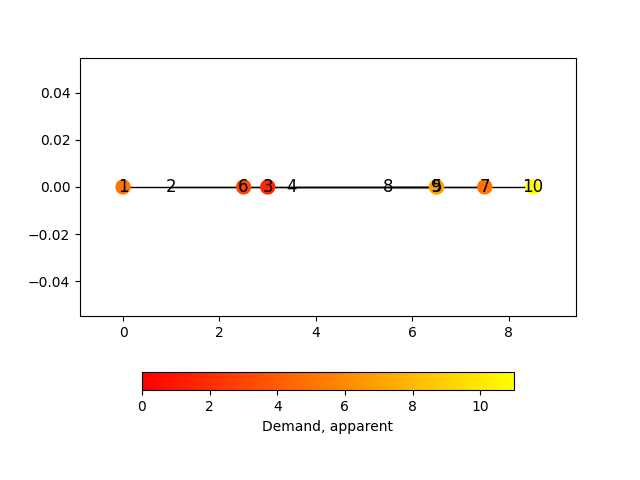

In [2]:
# Create a Grid object from a given configuration file
power_grid = Grid('grids/test_grid.yaml')

# Draw initial grid with all angles to 0
draw_grid(power_grid)

The distances between each bus is given by the various line lenghts in the config file. We can then configure the placement of each bus by assigning values to the branch angles $phi$.

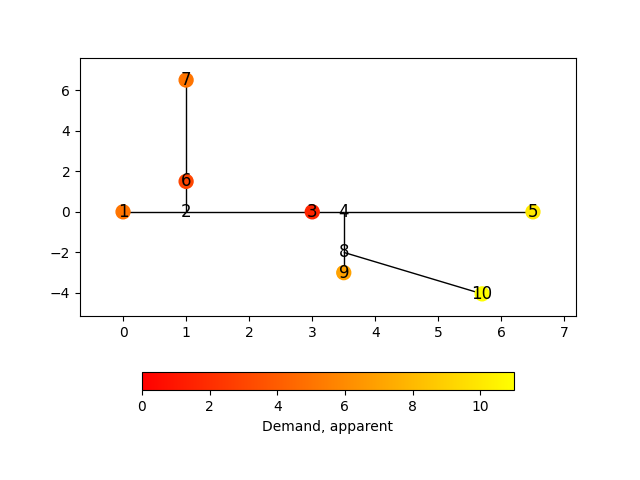

In [3]:
# Change angles like in the YAML-file drawing and draw again
power_grid.branch_angles[('2', '6')] = 90
power_grid.branch_angles[('6', '7')] = 90
power_grid.branch_angles[('4', '8')] = 270
power_grid.branch_angles[('8', '9')] = 270
power_grid.branch_angles[('8', '10')] = 317
draw_grid(power_grid)

Note that we can zoom and move around the graph with the buttons on the left. 
After having assigned angles to each branch, we can get the cartesian coordinates
of each bus with the function `Grid.get_bus_coordinates()`.

In [4]:
positions = power_grid.get_bus_coordinates()
positions

{'1': (0, 0),
 '2': (1.0, 0.0),
 '3': (3.0, 0.0),
 '4': (3.5, 0.0),
 '5': (6.5, 0.0),
 '8': (3.4999999999999996, -2.0),
 '9': (3.4999999999999996, -3.0),
 '10': (5.694061104857512, -4.045995080187495),
 '6': (1.0, 1.5),
 '7': (1.0000000000000002, 6.5)}

We can also find the distance between buses with `euclidian_distance()`.

In [5]:
euclidian_distance(positions['5'], positions['10'])

4.125483449440188

After the bus positions are specified, we can start adding base stations. They are given a name and a (x, y)-position as shown below. we can also draw them in the same figure with `draw_base_stations()`.

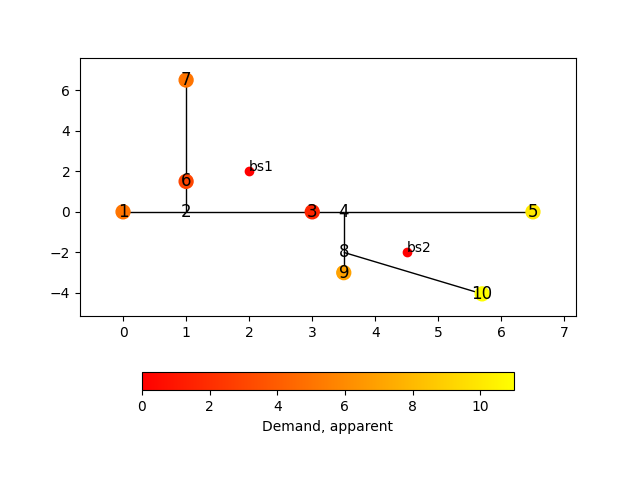

In [6]:
# Add base stations and draw them together with the grid
base_stations = {
    'bs1': (2, 2),
    'bs2': (4.5, -2)
}

draw_grid(power_grid)
draw_base_stations(base_stations)

When the base stations are in place we can use `base_station_distances()` to get a map of the distances from each bus to each base station. Note that the format can trivially be imported into a pandas DataFrame if we want.

In [7]:
# Generate a table of distances from each bus to each base station
dists = base_station_distances(power_grid, base_stations)
dists

{'1': {'bs1': 2.8284271247461903, 'bs2': 4.924428900898052},
 '2': {'bs1': 2.23606797749979, 'bs2': 4.031128874149275},
 '3': {'bs1': 2.23606797749979, 'bs2': 2.5},
 '4': {'bs1': 2.5, 'bs2': 2.23606797749979},
 '5': {'bs1': 4.924428900898052, 'bs2': 2.8284271247461903},
 '6': {'bs1': 1.118033988749895, 'bs2': 4.949747468305833},
 '7': {'bs1': 4.6097722286464435, 'bs2': 9.192388155425117},
 '8': {'bs1': 4.272001872658765, 'bs2': 1.0000000000000004},
 '9': {'bs1': 5.220153254455275, 'bs2': 1.4142135623730954},
 '10': {'bs1': 7.0852059924939725, 'bs2': 2.3689402251397094}}

Individual distances can be queried like this:

In [8]:
dists['3']['bs2']

2.5

Lastly, the tool includes a function for randomizing the layout of a grid called `Grid.randomize_placement()`.
It can be given a seed as argument, and will always generate the same layout if given the same seed.
Alternatively it can be called without an argument (or with `None`), in which case it will pick a seed at random.
The function will always return the seed that was used, so any layout that is "stumbled upon" in this way can be recreated
later if the seed is recorded.

It is of course possible to start with a random seed and then adjust the branch angles as normal afterwards.

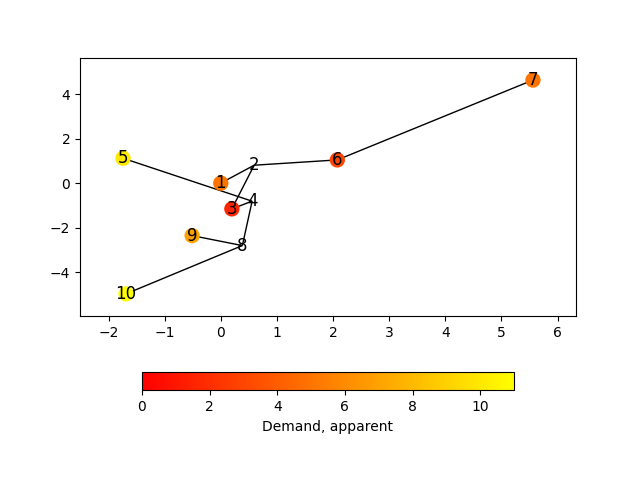

In [9]:
# Generate a random bus placement and draw the result
random_grid = Grid('grids/test_grid.yaml')
random_grid.randomize_placement()
draw_grid(random_grid)